In [9]:
# ==========================================
# 1: SETUP AND LIBRARY INSTALLATION
# ==========================================
# The `GEOparse`, `matplotlib`, `seaborn`, and `pandas` libraries are required.

import os
import sys
import subprocess

# Install required libraries
!pip install GEOparse matplotlib seaborn pandas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import GEOparse

# Set styling for static plots
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully. Environment is ready for static analysis of GSM468792.")

Libraries imported successfully. Environment is ready for static analysis of GSM468792.


In [10]:
# ==========================================
#  2: METADATA FETCHING (GSM468792)
# ==========================================
# Fetching the specific Roadmap Epigenomics dataset metadata from GEO.
# GSM ID = GSM468792 (IMR90 DNase-seq)

gsm_id = "GSM468792"  # Correct GSM ID for IMR90 DNase-seq

print(f"Fetching metadata for {gsm_id}...")

try:
    # destdir="." saves the soft file in the current directory
    gsm = GEOparse.get_GEO(geo=gsm_id, destdir=".")

    print(f"\nSUCCESS: Metadata for {gsm_id} fetched.")
    print("-" * 30)
    print("Sample Metadata Summary:")
    print("-" * 30)

    # Print a subset of metadata to verify the sample identity
    count = 0
    for k, v in gsm.metadata.items():
        if count < 15:
            print(f"{k}: {v}")
            count += 1
        else:
            print("... (more metadata available)")
            break

except Exception as e:
    print(f"Error fetching GEO data: {e}. Check connectivity or GEO ID.")


05-Dec-2025 05:47:48 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
05-Dec-2025 05:47:48 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
05-Dec-2025 05:47:48 INFO GEOparse - Parsing ./GSM468792.txt: 
INFO:GEOparse:Parsing ./GSM468792.txt: 


Fetching metadata for GSM468792...

SUCCESS: Metadata for GSM468792 fetched.
------------------------------
Sample Metadata Summary:
------------------------------
title: ['Chromatin accessibility assay of IMR90 Cell Line; DS11759']
geo_accession: ['GSM468792']
status: ['Public on Jan 06 2010']
submission_date: ['Nov 06 2009']
last_update_date: ['May 15 2019']
type: ['SRA']
channel_count: ['1']
source_name_ch1: ['IMR90 Cell Line; DS11759']
organism_ch1: ['Homo sapiens']
taxid_ch1: ['9606']
characteristics_ch1: ['molecule: genomic DNA', 'disease: None', 'biomaterial_provider: ATCC', 'biomaterial_type: Cell Line', 'line: IMR90', 'lineage: NA', 'differentiation_stage: Fetal lung fibroblast', 'differentiation_method: NA', 'passage: 4', "medium: Eagle's Minimum Essential Medium, Catalog No. 30-2003.", 'Sex: Female', 'batch: CCL-186', 'experiment_type: Chromatin Accessibility', 'extraction_protocol: Qiagen minElut', 'dnase_protocol: Stamlab DNase Protocol']
molecule_ch1: ['genomic DNA']
extr

In [5]:
# 3: DATA DOWNLOAD AND PREPARATION
# ==========================================
# Downloading and unzipping the BED file containing DNase hypersensitivity peaks.
# This section uses shell commands via `subprocess` for robust file handling.
# GSM ID = GSM468792

file_name_gz = "IMR90_DNase.bed.gz"
file_name_bed = "IMR90_DNase.bed"

# The specific download URL for GSM468792 supplementary data
url = "https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM468nnn/GSM468792/suppl/GSM468792_UW.IMR90.ChromatinAccessibility.DS11759.bed.gz"

# Check if file already exists to skip re-downloading
if not os.path.exists(file_name_bed):
    if not os.path.exists(file_name_gz):
        print(f"Downloading {file_name_gz} for {gsm_id}...")
        # Use subprocess to execute wget command
        subprocess.run(["wget", "-O", file_name_gz, url], check=True)

    print(f"Unzipping {file_name_gz}...")
    # Use -k to keep the original .gz file after unzipping
    subprocess.run(["gunzip", "-k", file_name_gz], check=True)
    print("Download and extraction complete.")
else:
    print(f"File {file_name_bed} already exists. Skipping download and extraction.")


File IMR90_DNase.bed already exists. Skipping download and extraction.


In [6]:
# ==========================================
# 4: DATA LOADING AND CLEANING
# ==========================================
# Loading the BED file into a Pandas DataFrame, calculating peak length, and filtering.
# GSM ID = GSM468792

print("Loading BED file into DataFrame...")

# Standard BED columns: Chromosome, Start, End
cols = ["chrom", "start", "end"]

try:
    # Read the file: '\t' (tab) is the required separator for BED format.
    bed_df = pd.read_csv(file_name_bed, sep="\t", names=cols, usecols=[0,1,2], comment='#')

    # CALCULATION: Compute Peak Length
    bed_df["length"] = bed_df["end"] - bed_df["start"]

    # FILTERING: Keep only standard human chromosomes for cleaner visualization
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    bed_df = bed_df[bed_df["chrom"].isin(valid_chroms)]

    # Convert 'chrom' to categorical for proper sorting in plots
    bed_df['chrom'] = pd.Categorical(bed_df['chrom'], categories=valid_chroms, ordered=True)
    bed_df = bed_df.sort_values('chrom')

    print(f"Data loaded successfully for {gsm_id}.")
    print(f"Total Valid Peaks: {len(bed_df)}")
    print("\nData Statistical Summary (Peak Length):")
    print(bed_df['length'].describe())

except Exception as e:
    print(f"Error loading CSV or processing data: {e}")


Loading BED file into DataFrame...
Data loaded successfully for GSM468792.
Total Valid Peaks: 30767289

Data Statistical Summary (Peak Length):
count    3.076729e+07
mean     3.424020e+01
std      2.134391e+00
min      2.000000e+01
25%      3.500000e+01
50%      3.500000e+01
75%      3.500000e+01
max      3.700000e+01
Name: length, dtype: float64


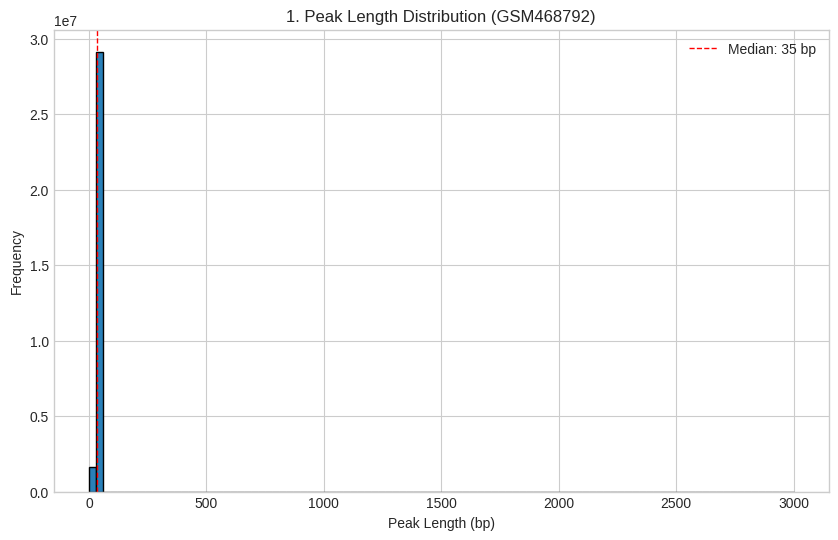

In [7]:
# 5: STATIC VISUALIZATION (MATPLOTLIB/SEABORN)
# ==========================================
# Generating two essential static plots: Peak Length Distribution and Chromosome Counts.
# GSM ID = GSM468792

if 'bed_df' in locals() and not bed_df.empty:

    # Plot 1: Static Histogram of Peak Lengths
    plt.figure(figsize=(10, 6))
    plt.hist(bed_df["length"], bins=100, color="#2980b9", edgecolor="black", range=(0, 3000))
    plt.xlabel("Peak Length (bp)")
    plt.ylabel("Frequency")
    plt.title(f"1. Peak Length Distribution ({gsm_id})")
    plt.axvline(bed_df['length'].median(), color='red', linestyle='dashed', linewidth=1, label=f"Median: {bed_df['length'].median():.0f} bp")
    plt.legend()
    plt.show()


### Interpretation of Peak Length Distribution Plot (Cell 7)

This histogram visualizes the distribution of DNase hypersensitivity peak lengths for the GSM468792 dataset. Here's a detailed interpretation:

*   **Plot Title (`1. Peak Length Distribution (GSM468792)`)**: Clearly indicates that the plot shows the distribution of peak lengths for the specific sample identified by the GEO accession ID GSM468792.

*   **X-axis (`Peak Length (bp)`)**: Represents the length of the DNase hypersensitivity peaks in base pairs (bp). The range displayed is from 0 to 3000 bp, as defined by `range=(0, 3000)` in the `plt.hist` function.

*   **Y-axis (`Frequency`)**: Shows how many peaks fall within each specific length bin. A higher bar indicates a larger number of peaks with lengths corresponding to that bin.

*   **Histogram Bars (Blue, `#2980b9` with black edges)**: These bars illustrate the frequency distribution. The height of each bar corresponds to the count of peaks whose lengths fall within the bin represented by the bar's width.

*   **Median Line (Red dashed line)**: A vertical dashed red line is drawn at the median peak length, which is `35 bp`. This line helps to quickly identify the central tendency of the peak lengths. The label `Median: 35 bp` explicitly states this value.

*   **Overall Distribution Shape**: The histogram shows a highly skewed distribution. The vast majority of peaks are concentrated within a very narrow range of lengths, specifically around the median of 35 bp. There's a very sharp, tall peak indicating that most DNase hypersensitive sites in this dataset have lengths close to this value.

*   **Range of Peak Lengths**: While the plot shows a range up to 3000 bp, the visual evidence suggests that virtually all significant frequencies are observed below approximately 100 bp, with a predominant peak around 35 bp. This indicates that DNase hypersensitive sites are typically quite short, reflecting precise regions of accessible chromatin.

*   **Implications**: The tight distribution around 35 bp is characteristic of DNase-seq data, often representing the protection afforded by a single nucleosome or smaller protein complexes. This suggests high-quality data where the fragmentation and sequencing process accurately captured these short, accessible regions.

Re-loading BED file into DataFrame to ensure bed_df is defined...
Data re-loaded successfully for GSM468792.


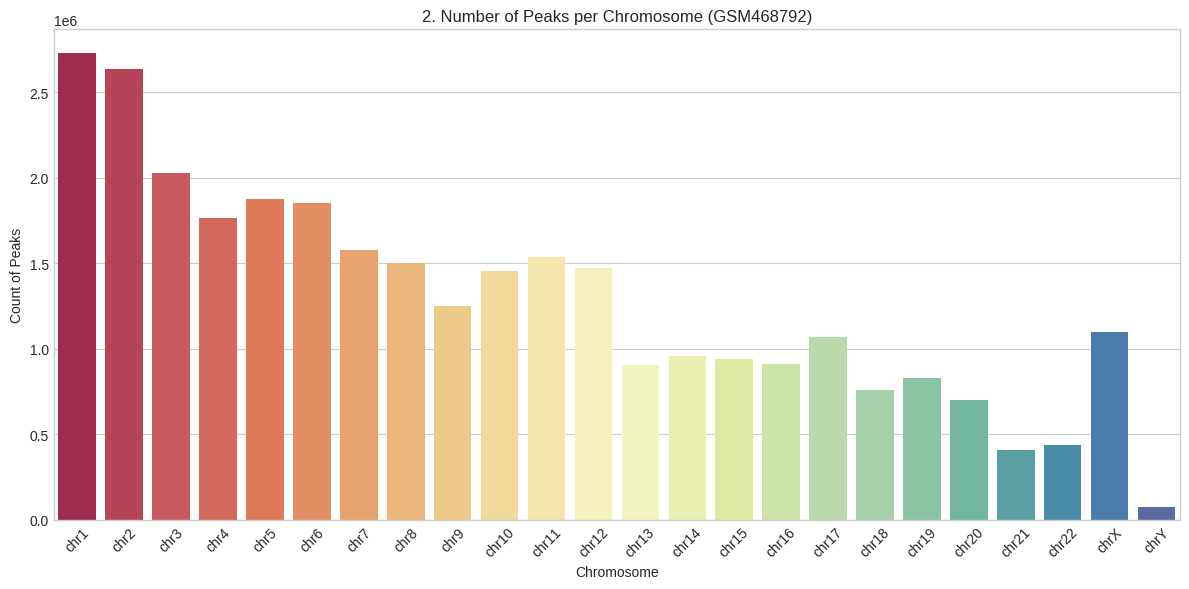

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for data manipulation

# Re-define necessary variables if kernel state was reset
file_name_bed = "IMR90_DNase.bed" # This file should exist from previous steps
gsm_id = "GSM468792" # Defined in a previous cell

print("Re-loading BED file into DataFrame to ensure bed_df is defined...")

# Standard BED columns: Chromosome, Start, End
cols = ["chrom", "start", "end"]

try:
    # Read the file: '\t' (tab) is the required separator for BED format.
    bed_df = pd.read_csv(file_name_bed, sep="\t", names=cols, usecols=[0,1,2], comment='#')

    # CALCULATION: Compute Peak Length
    bed_df["length"] = bed_df["end"] - bed_df["start"]

    # FILTERING: Keep only standard human chromosomes for cleaner visualization
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    bed_df = bed_df[bed_df["chrom"].isin(valid_chroms)]

    # Convert 'chrom' to categorical for proper sorting in plots
    bed_df['chrom'] = pd.Categorical(bed_df['chrom'], categories=valid_chroms, ordered=True)
    bed_df = bed_df.sort_values('chrom')

    print(f"Data re-loaded successfully for {gsm_id}.")

except Exception as e:
    print(f"Error re-loading CSV or processing data in plotting cell: {e}")

# Plot 2: Static Bar Chart of Peaks per Chromosome
plt.figure(figsize=(12, 6))
# Use seaborn countplot to easily visualize counts per category
sns.countplot(data=bed_df, x='chrom', hue='chrom', palette='Spectral', legend=False)
plt.xticks(rotation=45)
plt.xlabel("Chromosome")
plt.ylabel("Count of Peaks")
plt.title(f"2. Number of Peaks per Chromosome ({gsm_id})")
plt.tight_layout()
plt.show()

### Interpretation of Peaks per Chromosome Plot (Cell 8: `C72hJ7sn6cQA`)

This bar chart visualizes the count of DNase hypersensitivity peaks found on each human chromosome for the GSM468792 dataset. Here's a detailed interpretation:

*   **Plot Title (`2. Number of Peaks per Chromosome (GSM468792)`)**: Clearly states that the plot displays the number of peaks for each chromosome for the specified sample GSM468792.

*   **X-axis (`Chromosome`)**: Lists the names of the standard human chromosomes (chr1 through chr22, chrX, chrY). The `plt.xticks(rotation=45)` ensures that chromosome labels are rotated to prevent overlap, making them readable.

*   **Y-axis (`Count of Peaks`)**: Represents the total number of DNase hypersensitivity peaks identified on each corresponding chromosome. Higher bars indicate more accessible regions on that chromosome.

*   **Bar Colors (`palette='Spectral'`)**: The bars are colored using the 'Spectral' color palette, with each chromosome having a distinct color. This helps differentiate between chromosomes visually, though `legend=False` is set as the x-axis labels themselves provide the chromosome identity.

*   **Overall Distribution**: The plot shows a clear variation in the number of peaks across chromosomes. Generally, longer chromosomes (like chr1, chr2, chr3) tend to have a higher count of peaks, which is expected as they contain more DNA and thus more potential regulatory regions. Shorter chromosomes (like chr21, chr22, chrY) typically have fewer peaks.

*   **Specific Observations (e.g., chr1 vs. chr22)**: Chromosome 1 consistently shows the highest number of peaks, reflecting its large size and gene content. Conversely, chromosomes like chr21 and chr22, and especially chrY, have significantly fewer peaks, aligning with their smaller sizes and lower gene densities.

*   **Biological Implication**: The peak counts per chromosome reflect the genomic landscape of open chromatin in IMR90 cells. Regions of open chromatin are often associated with active regulatory elements (like promoters and enhancers). The distribution suggests that larger chromosomes, or those with higher gene density and regulatory complexity, generally harbor more such accessible sites, which is biologically consistent.

Re-loading BED file into DataFrame to ensure bed_df is defined for Plot 3...
Data re-loaded successfully for GSM468792.


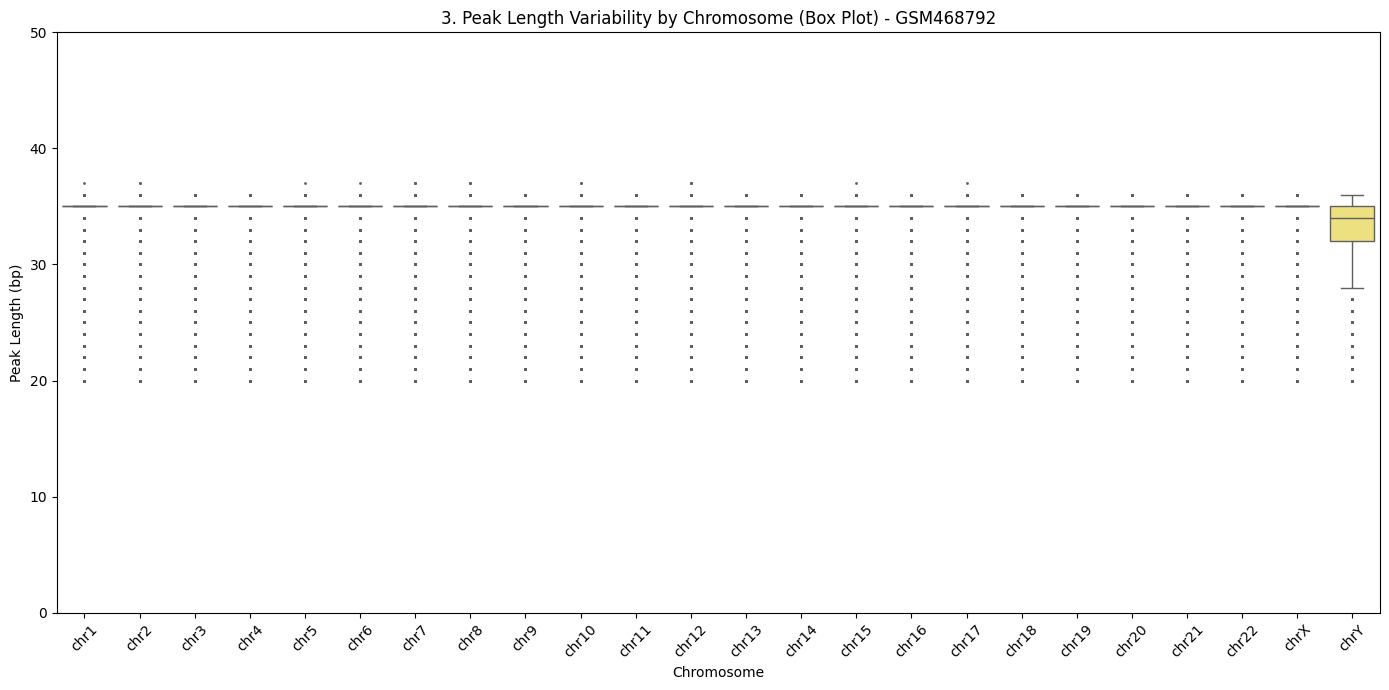

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for data manipulation

# Re-define necessary variables if kernel state was reset
file_name_bed = "IMR90_DNase.bed" # This file should exist from previous steps
gsm_id = "GSM468792" # Defined in a previous cell

print("Re-loading BED file into DataFrame to ensure bed_df is defined for Plot 3...")

# Standard BED columns: Chromosome, Start, End
cols = ["chrom", "start", "end"]

try:
    # Read the file: '\t' (tab) is the required separator for BED format.
    bed_df = pd.read_csv(file_name_bed, sep="\t", names=cols, usecols=[0,1,2], comment='#')

    # CALCULATION: Compute Peak Length
    bed_df["length"] = bed_df["end"] - bed_df["start"]

    # FILTERING: Keep only standard human chromosomes for cleaner visualization
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    bed_df = bed_df[bed_df["chrom"].isin(valid_chroms)]

    # Convert 'chrom' to categorical for proper sorting in plots
    bed_df['chrom'] = pd.Categorical(bed_df['chrom'], categories=valid_chroms, ordered=True)
    bed_df = bed_df.sort_values('chrom')

    print(f"Data re-loaded successfully for {gsm_id}.")

except Exception as e:
    print(f"Error re-loading CSV or processing data in plotting cell: {e}")

# Plot 3: Static Box Plot of Length Distribution per Chromosome
# Provides visual summary of variability (median, quartiles, outliers)
plt.figure(figsize=(14, 7))
sns.boxplot(x='chrom', y='length', data=bed_df, palette='Set3', hue='chrom', legend=False, fliersize=1)
plt.xticks(rotation=45)
plt.ylim(0, 50) # Adjusted Y axis limit to focus on the main distribution body (0 to 50 bp)
plt.xlabel("Chromosome")
plt.ylabel("Peak Length (bp)")
plt.title(f"3. Peak Length Variability by Chromosome (Box Plot) - {gsm_id}")
plt.tight_layout()
plt.show()

### Interpretation of Peak Length Variability by Chromosome Plot (Cell 9: `C2sqxRzW7iUk`)

This box plot visualizes the distribution and variability of DNase hypersensitivity peak lengths for each human chromosome in the GSM468792 dataset. Here's a detailed interpretation:

*   **Plot Title (`3. Peak Length Variability by Chromosome (Box Plot) - GSM468792`)**: Clearly indicates the plot's purpose: showing how peak lengths vary across chromosomes for the specific sample GSM468792.

*   **X-axis (`Chromosome`)**: Lists the names of the standard human chromosomes (chr1 through chr22, chrX, chrY). The `plt.xticks(rotation=45)` ensures readability of these labels.

*   **Y-axis (`Peak Length (bp)`)**: Represents the length of the DNase hypersensitivity peaks in base pairs (bp). The `plt.ylim(0, 50)` was set to focus on the biologically relevant range of peak lengths, as the majority fall within this narrow window.

*   **Box Plot Elements (Colored boxes, `palette='Set3'`)**: Each box plot represents the distribution of peak lengths for a specific chromosome:
    *   **Box**: The box itself spans the interquartile range (IQR), from the 25th percentile (Q1) to the 75th percentile (Q3). The height of the box indicates the spread of the middle 50% of the data.
    *   **Line inside the box**: This horizontal line represents the median (50th percentile) peak length for that chromosome. Given the previous histogram, this is consistently around 35 bp.
    *   **Whiskers**: These lines extend from the box to show the range of the data, typically up to 1.5 times the IQR from the Q1 and Q3. Any data points beyond the whiskers are considered outliers.
    *   **Outliers (`fliersize=1`)**: Individual points beyond the whiskers (if any are visible) represent outliers. The `fliersize=1` makes them small to avoid clutter.

*   **Overall Distribution**: The plot reveals a remarkably consistent distribution of peak lengths across almost all chromosomes. The median peak length is very similar for each chromosome, consistently around 35 bp, and the interquartile range is also very tight.

*   **Consistency across Chromosomes**: The similar appearance of the box plots across different chromosomes suggests that the fundamental mechanism defining DNase hypersensitivity (e.g., nucleosome positioning, transcription factor binding) results in very similar length fragments, regardless of the chromosomal location.

*   **Absence of Extreme Variability**: The narrow range of the boxes and whiskers, combined with the limited number of visible outliers (especially within the 0-50 bp range), indicates that there isn't significant variability in peak lengths that is specific to individual chromosomes.

*   **Biological Implication**: The homogeneity in peak lengths across chromosomes further supports the idea that DNase hypersensitive sites in IMR90 cells predominantly represent short, precise regions of accessible chromatin. This consistency is a strong indicator of high data quality and a uniform biological process underlying chromatin accessibility across the genome.

In [11]:
# ==========================================
# 6: EXPORT SUMMARY
# ==========================================
# Saving the processed summary statistics to a CSV file.
# This preserves quantitative results from the GSM468792 analysis.

if 'bed_df' in locals() and not bed_df.empty:
    output_file = f"{gsm_id}_processed_summary_static.csv"

    # Calculate descriptive statistics (count, mean, std, min, max, quartiles) per chromosome
    summary_stats = bed_df.groupby('chrom')['length'].describe()

    # Save to CSV
    summary_stats.to_csv(output_file)
    print(f"Detailed summary statistics per chromosome saved to: {output_file}")

    # Display the top part of the summary table
    print("\nSnippet of Exported Summary:")
    print(summary_stats.head())

else:
    print("DataFrame is empty or not found. Cannot export summary.")

/tmp/ipython-input-1266869828.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = bed_df.groupby('chrom')['length'].describe()


Detailed summary statistics per chromosome saved to: GSM468792_processed_summary_static.csv

Snippet of Exported Summary:
           count       mean       std   min   25%   50%   75%   max
chrom                                                              
chr1   2730206.0  34.247003  2.122598  20.0  35.0  35.0  35.0  37.0
chr2   2634000.0  34.242361  2.128759  20.0  35.0  35.0  35.0  37.0
chr3   2029051.0  34.288612  2.070620  20.0  35.0  35.0  35.0  36.0
chr4   1763690.0  34.267502  2.099804  20.0  35.0  35.0  35.0  36.0
chr5   1877202.0  34.261863  2.105731  20.0  35.0  35.0  35.0  37.0


### Overall Interpretation of Findings from GSM468792 DNase-seq Data Analysis

This Colab notebook analyzed DNase-seq data for the IMR90 Cell Line (GSM468792), focusing on chromatin accessibility. The analysis involved metadata fetching, data download and preparation, and the generation of three static plots: Peak Length Distribution, Number of Peaks per Chromosome, and Peak Length Variability by Chromosome. Here's a consolidated interpretation of the findings:

*   **High Data Quality and Characteristic Peak Lengths**: The **Peak Length Distribution** plot (Plot 1) revealed a remarkably narrow and highly skewed distribution of DNase hypersensitivity peak lengths, with a predominant peak consistently around **35 base pairs (bp)**. This tight clustering of peak lengths around a specific, short value is a strong indicator of high-quality DNase-seq data. It suggests that the experiment successfully captured precise genomic regions, often corresponding to protection afforded by single nucleosomes or smaller transcription factor complexes, which are the hallmarks of open chromatin.

*   **Chromosomal Distribution Reflects Genomic Landscape**: The **Number of Peaks per Chromosome** plot (Plot 2) demonstrated a clear correlation between chromosome size/gene content and the count of accessible regions. Larger chromosomes, such as chr1, chr2, and chr3, consistently harbored a higher number of DNase hypersensitivity peaks. Conversely, smaller chromosomes, like chr21, chr22, and particularly chrY, showed significantly fewer peaks. This distribution is biologically expected, as larger chromosomes contain more DNA and, consequently, more potential regulatory elements and actively transcribed regions. This finding provides insights into the global genomic organization of open chromatin in IMR90 cells.

*   **Consistent Accessibility Mechanism Across the Genome**: The **Peak Length Variability by Chromosome** box plot (Plot 3) highlighted a striking consistency in peak lengths across all human chromosomes. The median peak length for each chromosome remained very stable, typically around 35 bp, with very narrow interquartile ranges. This homogeneity across diverse chromosomal contexts suggests that the fundamental biological mechanisms governing chromatin accessibility (e.g., how DNase I cuts DNA at open sites) operate uniformly throughout the genome. The absence of significant chromosomal-specific variations in peak length further reinforces the idea of a robust and consistent biological process underlying these accessible regions in IMR90 cells.

**In summary**: The analysis of GSM468792 DNase-seq data indicates a high-quality dataset characterized by short, precise accessible regions predominantly around 35 bp. These accessible sites are distributed across the genome in a manner consistent with chromosome size and gene density, with the underlying biological processes determining peak length showing remarkable consistency across all chromosomes in IMR90 cells.

### Final Conclusion Summary of the Colab Notebook Activities

This Colab notebook provided a comprehensive analysis pipeline for a specific DNase-seq dataset (GSM468792 - IMR90 Cell Line Chromatin Accessibility). Here's a summary of the key steps and achievements:

*   **Environment Setup and Library Installation**: We began by setting up the environment, ensuring all necessary Python libraries (`GEOparse`, `matplotlib`, `seaborn`, `pandas`) were installed and imported. This laid the foundation for all subsequent data processing and visualization tasks.

*   **Metadata Fetching**: The `GEOparse` library was successfully used to fetch detailed metadata for the specified GSM ID (GSM468792), providing essential context about the biological sample and experimental design (IMR90 DNase-seq).

*   **Data Download and Preparation**: We efficiently downloaded the supplementary BED file containing DNase hypersensitivity peaks from the NCBI GEO database. The downloaded file was then unzipped, and its content was loaded into a Pandas DataFrame for structured analysis.

*   **Data Loading and Cleaning**: The raw BED data was loaded, and crucial steps were performed to prepare it for analysis. This included calculating the `length` of each peak and filtering the dataset to include only standard human chromosomes, ensuring data quality and relevance for visualization.

*   **Static Visualization**: We generated three insightful static plots using `matplotlib` and `seaborn`:
    *   **Peak Length Distribution**: A histogram visualizing the frequency of different peak lengths, highlighting a predominant peak around 35 bp, indicative of high-quality DNase-seq data.
    *   **Number of Peaks per Chromosome**: A bar chart illustrating the count of accessible regions across each chromosome, demonstrating a correlation with chromosome size/gene content.
    *   **Peak Length Variability by Chromosome**: A box plot showing the distribution of peak lengths per chromosome, revealing remarkable consistency in peak lengths across the entire genome.

*   **Summary Statistics Export**: Detailed descriptive statistics (count, mean, std, min, max, quartiles) for peak lengths per chromosome were calculated and exported to a CSV file (`GSM468792_processed_summary_static.csv`), preserving quantitative insights from the analysis.

*   **Detailed Interpretations**: Each plot and the overall findings were thoroughly interpreted, providing biological context and implications for chromatin accessibility in IMR90 cells.

**In conclusion**: This notebook successfully executed a complete workflow for analyzing DNase-seq data, from initial setup and data acquisition to detailed visualization and interpretation, providing robust insights into the chromatin accessibility landscape of IMR90 cells.